<h1>IUM Etap 1</h1>

**Problem biznesowy**
Chcemy polecać klientom sklepu dopasowane do nich produkty tak aby sklep zarobił jak najwięcej na ich polecaniu

**Zadanie modelowania**
Dla aktualnego użytkownika chcemy polecić M produktów, których polecenie powinno zmaksymalizować liczbę wydanych przez użytkownika pieniędzy.
Wejście: historia aktualnej sesji, historia wszystkich sesji.
Wyjście: Lista M produktów rekomendowanych przez nasz model.

**Kryterium sukcesu**
Model przyczynia się do zauważalnego wzrostu zarobków wynikających ze sprzedaży w sklepie.


In [1]:
import ast
import re
import pandas as pd
import math
import numpy as np

Dane są w formacie jsonl. Konwertujemy je do json.

In [2]:
def read_data(path):
    with open(path, 'r') as f:
        lines = f.readlines() 
        
    json_formatted = '['
    for line in lines:
        json_formatted += line + ','
    json_formatted = json_formatted[:-1] + ']' 
    json_formatted = re.sub('null', 'None', json_formatted)
    return ast.literal_eval(json_formatted)

In [3]:
drive = 'data/'

#df_deliveries = pd.DataFrame(read_data(drive + 'deliveries.jsonl'))
df_products = pd.DataFrame(read_data(drive + 'products.jsonl'))
df_sessions = pd.DataFrame(read_data(drive + 'sessions.jsonl'))
df_users = pd.DataFrame(read_data(drive + 'users.jsonl'))

Tabela deliveries nie zawiera danych związanych z naszym zadaniem, w związku z czym nie będziemy jej dalej analizować.

In [4]:
df_sessions['timestamp'] = pd.to_datetime(df_sessions['timestamp'])

In [5]:
df_sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,100001,2020-03-26 22:22:04,102.0,1276.0,VIEW_PRODUCT,0,NaN
1,100001,2020-03-26 22:26:16,102.0,1276.0,BUY_PRODUCT,0,20001.0
2,100002,2020-01-02 01:45:52,102.0,1234.0,VIEW_PRODUCT,5,NaN
3,100002,2020-01-02 01:48:45,102.0,1233.0,VIEW_PRODUCT,5,NaN
4,100002,2020-01-02 01:52:29,102.0,1233.0,BUY_PRODUCT,5,20002.0


In [6]:
df_products.head()

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99


Czasem brakuje danych dotyczących produktów, które są obejrzane/kupione. Nie da się ich w żaden sposób odzyskać, więc usuniemy wybrakowane rzędy:

In [7]:
print(df_sessions.shape)
df_sessions = df_sessions[df_sessions["product_id"].notna()]
print(df_sessions.shape)

(91653, 7)
(86987, 7)


Niektóre nazwy użytkowników w tabeli sessions są wybrakowane. Użyjemy informacji o sesjach do uzupełnienia ich.

In [8]:
print("Ilość wierszy z nienullowym user_id:", df_sessions[df_sessions["user_id"].notna()].shape[0])
print("Ilość wierszy z nullowym user_id:", df_sessions[df_sessions["user_id"].isna()].shape[0])

# https://stackoverflow.com/questions/46718178/dataframe-columns-to-key-value-dictionary-pair
session_dict = df_sessions[df_sessions["user_id"].notna()].set_index('session_id').to_dict()
session_to_user_map = session_dict['user_id']

for index, row in df_sessions.iterrows():
    if row["session_id"] in session_to_user_map and np.isnan(row["user_id"]):
        df_sessions.at[index, 'user_id'] = session_to_user_map[row["session_id"]]

print("Ilość wierszy z nienullowym user_id po poprawce:", df_sessions[df_sessions["user_id"].notna()].shape[0])
print("Ilość wierszy z nullowym user_id po poprawce:", df_sessions[df_sessions["user_id"].isna()].shape[0])

df_sessions = df_sessions[df_sessions["user_id"].notna()]

print("Ilość wierszy po usunieciu wadliwych danych:", df_sessions.shape[0])

Ilość wierszy z nienullowym user_id: 82622
Ilość wierszy z nullowym user_id: 4365
Ilość wierszy z nienullowym user_id po poprawce: 86923
Ilość wierszy z nullowym user_id po poprawce: 64
Ilość wierszy po usunieciu wadliwych danych: 86923


Przeprowadzamy analizę popularności produktów w zależności od tygodnia w roku, aby znaleźć potencjalne trendy.

In [9]:
import matplotlib.pyplot as plt

def plot_timeseries(df, column, n=10, df_labels=None, labels_column=None):
  cnt = df[column].value_counts()
  print(f'Unique values in "{column}": {len(cnt)}')
  idx = cnt.head(n).index
  plt.figure(figsize=(20, n))
  for i in range(n):
      plt.subplot(math.ceil(n / 5), 5, i+1)
      if df_labels is not None:
        plt.title(df_labels.loc[df_labels[column] == idx[i], labels_column].squeeze())
      else:
        plt.title(idx[i])
      temp = df[df[column] == idx[i]]
      temp.groupby([temp['timestamp'].dt.isocalendar().week])[column].count().plot()
  plt.show()


Unique values in "product_id": 217


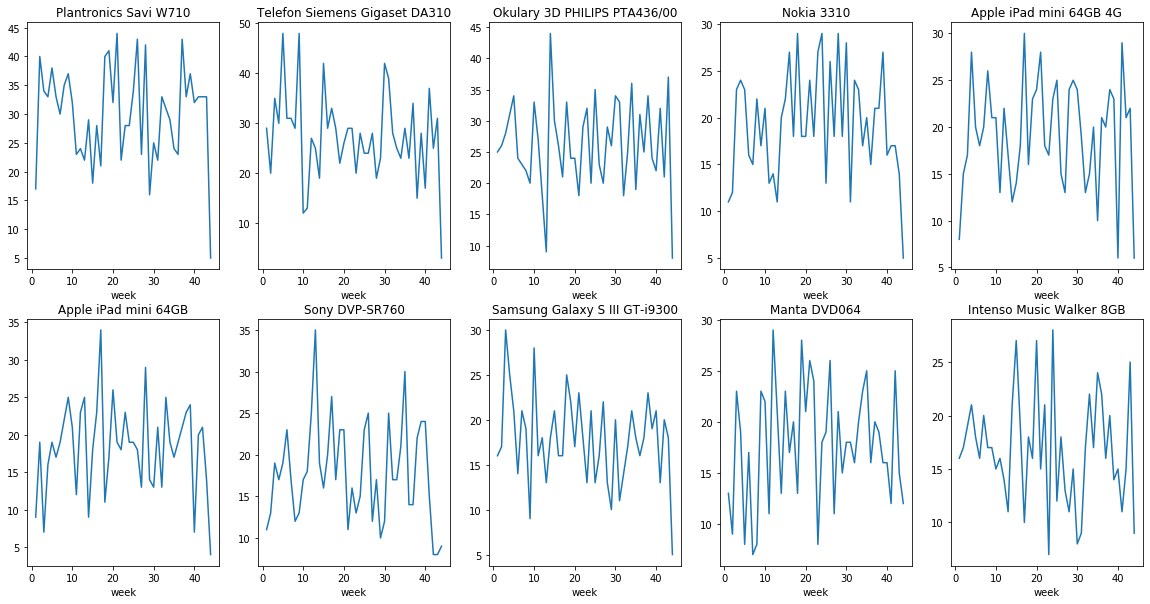

In [10]:
plot_timeseries(df_sessions, 'product_id', df_labels=df_products, labels_column='product_name', n=10)

Z analizy popularności produktów w zależności od daty doszliśmy do wniosku, że nie ma żadnej korelacji między tymi dwoma wartościami. Z wykresów obrazujących te zależności można wywnioskować, że popularność produktów zawsze oscyluje wokół pewnej stałej wartości.

In [11]:
def get_corrcoef_for_column(df, column, n=100):
    cnt = df[column].value_counts()
    idx = cnt.head(n).index
    weeks = range(44)
    
    correlations = []
    
    for i in range(n):
        temp = df[df[column] == idx[i]]
        try:
            # ignore if some data is missing
            array = [temp.groupby([temp['timestamp'].dt.isocalendar().week])[column].count(), weeks]
            correlation = np.corrcoef(array)[1,0]
            print(correlation)
            correlations.append(correlation)
        except:
            pass
        
    print("\nMaximum correlation found: ", max(correlations))
    print("Minimum correlation found: ", min(correlations))


In [12]:
get_corrcoef_for_column(df_sessions, 'product_id')

-0.08610201918109797
-0.2293845029745816
-0.017065051741664873
-0.007609092718608851
-0.01819163790116199
-0.023124013969100424
-0.10265676964957657
-0.25125547034352613
0.12275956221641438
-0.11496260535978102
0.06970207032779148
-0.026238591426147623
0.03483740502595009
-0.03764221715851983
-0.006211127985426151
-0.0906600667169857
0.031605884434522
0.08291182491104153
0.027184898183922696
-0.10104268386883432
-0.21622648860527863
-0.19926171938158227
-0.15704043875840984
-0.15857557143087955
-0.12736090886583099
0.05583560815063766
-0.09551484766488777
-0.08947140561427903
0.1804393113343129
0.2606764717458011
0.007002187180664373
-0.18091206634613397
0.06195837038520493
-0.07844026107422877
-0.030273275663560827
-0.12439635923527735
-0.26864471426031117
0.29895508470380816
-0.02372554898576334
0.10825634578738992
0.19149365631169823
0.14302925321875096
0.20459528857142487
-0.17669127016136876
0.3170235267270701
0.029157354789558266
-0.02254792743169691
0.15208737560590252
0.0533189

Wyliczenie współczynnika korelacji dla produktów utwierdziło nas we wniosku, że dane nie są skorelowane. Nawet w najbardziej skrajnych przypadkach te korelacje są na tyle delikatne i jest ich tak mało, że wynikają bardziej z losowości. 

In [13]:
df = df_products.set_index('product_id')
df_sessions = df_sessions.dropna(subset=['product_id'])
df_sessions['product_id'] = df_sessions['product_id'].astype(int)
df = df_sessions.join(df, on='product_id')

Unique values in "category_path": 15


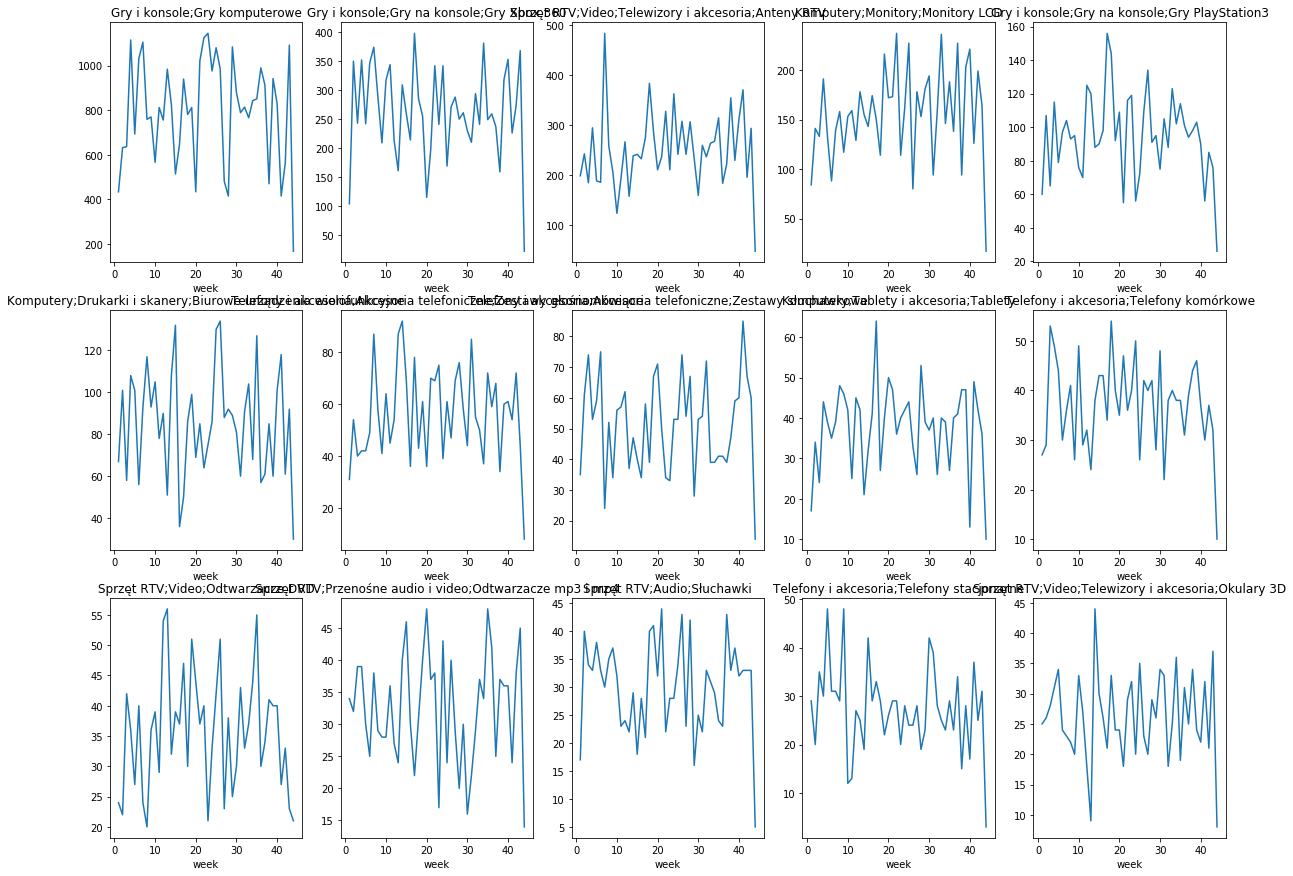

In [14]:
plot_timeseries(df, 'category_path', n=15)

In [15]:
len(df_products['category_path'].str.replace(';.*', '').unique())

4

Unique values in "category_path": 4


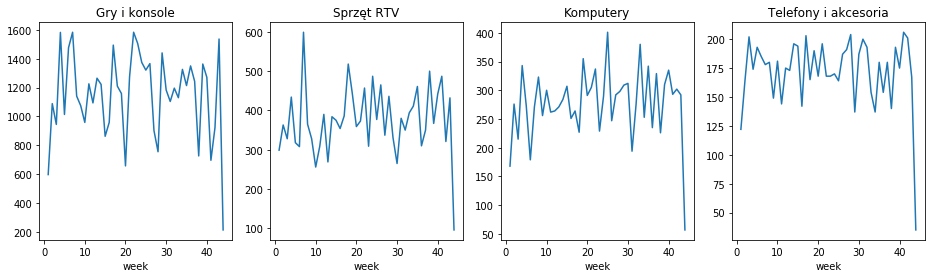

In [16]:
df_new = df.copy()
df_new['category_path'] = df_new['category_path'].str.replace(';.*', '')
plot_timeseries(df_new, 'category_path', n=4)

In [17]:
print("Korelacje dla wszystkich kategorii:")
get_corrcoef_for_column(df, 'category_path', 15)

print("\n\n\n")

print("Korelacje dla ogólnych kategorii:")
get_corrcoef_for_column(df_new, 'category_path', 4)

Korelacje dla wszystkich kategorii:
-0.06752249418364607
-0.11688722697302854
0.06753408311973741
0.1625405379702269
-0.12120093707588427
-0.09492699695956282
-0.014295832004618212
-0.010024106329820903
-0.023110394073105115
-0.1422888184442498
0.009164142855341001
-0.029274397818572325
-0.08610201918109797
-0.2293845029745816
-0.017065051741664873

Maximum correlation found:  0.1625405379702269
Minimum correlation found:  -0.2293845029745816




Korelacje dla ogólnych kategorii:
-0.09584741535120625
0.04820121525420019
0.08196262229357638
-0.12480655096528413

Maximum correlation found:  0.08196262229357638
Minimum correlation found:  -0.12480655096528413


Dla kategorii przeprowadziliśmy analogiczną analizę jak dla pojedynczych produktów. Ponownie nie ma znaczących korelacji. **W związku z tym, że nie ma trendów związanych z datą, to pominiemy ją w naszym modelu.**

<h1>Analiza zniżek</h1>

In [18]:
df = df_products.set_index('product_id')
df = df_sessions.join(df, on='product_id')

In [19]:
df.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,100001,2020-03-26 22:22:04,102.0,1276,VIEW_PRODUCT,0,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
1,100001,2020-03-26 22:26:16,102.0,1276,BUY_PRODUCT,0,20001.0,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
2,100002,2020-01-02 01:45:52,102.0,1234,VIEW_PRODUCT,5,NaN,Sony DVP-SR760,Sprzęt RTV;Video;Odtwarzacze DVD,193.00
3,100002,2020-01-02 01:48:45,102.0,1233,VIEW_PRODUCT,5,NaN,Manta DVD064,Sprzęt RTV;Video;Odtwarzacze DVD,109.00
4,100002,2020-01-02 01:52:29,102.0,1233,BUY_PRODUCT,5,20002.0,Manta DVD064,Sprzęt RTV;Video;Odtwarzacze DVD,109.00


In [20]:
df.shape

(86923, 10)

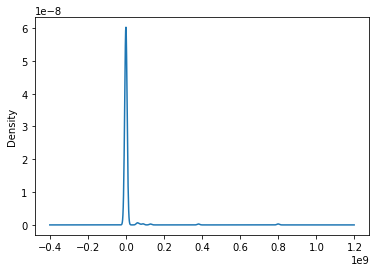

In [21]:
df['price'].plot.density()

Na potrzeby analizy usuwamy błędne ceny.

In [22]:
mask1 = df['price'] > 0
mask2 = df['price'] < 100_000

print('Cen ujemnych:', (~mask1).sum())
print('Cen za dużych:', (~mask2).sum())
print('W sumie usuwamy:', (~mask1).sum() + (~mask2).sum())

Cen ujemnych: 6208
Cen za dużych: 3583
W sumie usuwamy: 9791


In [23]:
df = df[mask1 & mask2]

In [24]:
df.shape

(77132, 10)

Text(0, 0.5, 'mean price')

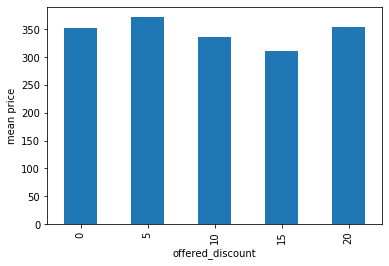

In [25]:
df.groupby('offered_discount')['price'].mean().plot(kind='bar')
plt.ylabel('mean price')

Jak widzimy cena produktu zakupionego przez klienta nie zależy od oferowanej mu zniżki. Nie jest więc tak, że klienci po dostaniu zniżki kupują droższe czy też tańsze produkty niż normalnie.

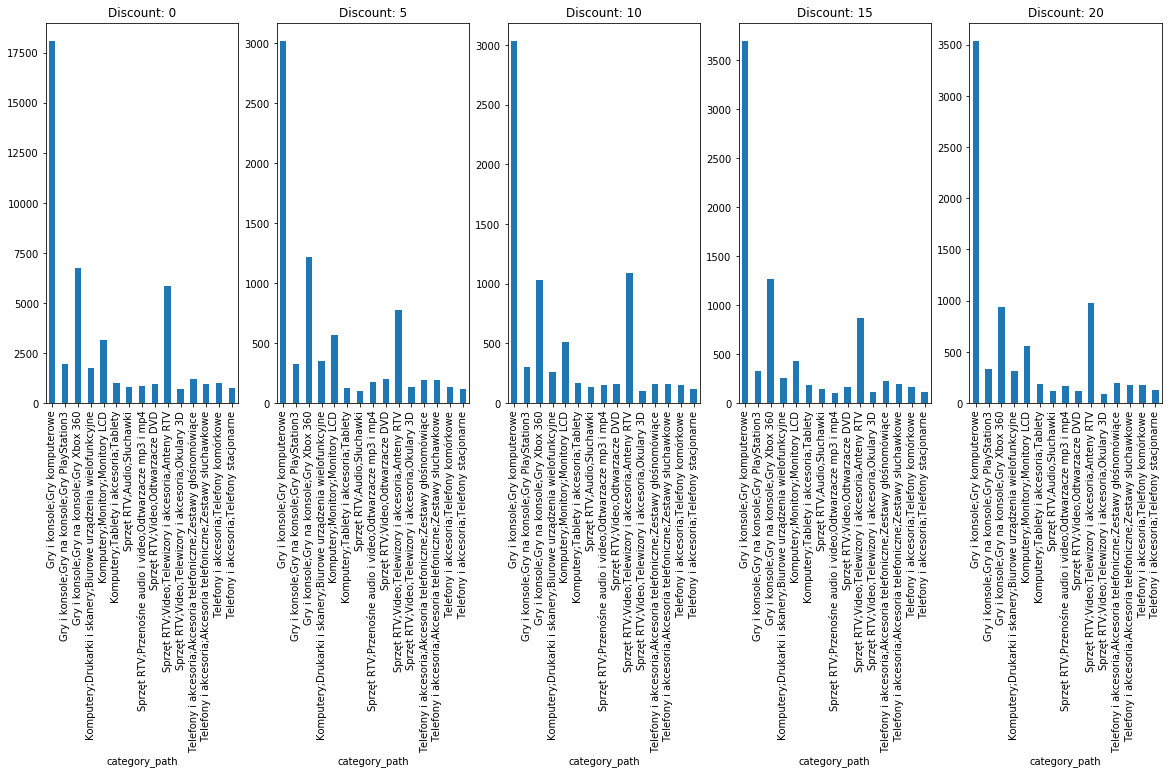

In [26]:
discounts = sorted(df['offered_discount'].unique())

plt.figure(figsize=(20, 7))
for i, discount in enumerate(discounts):
  plt.subplot(1, len(discounts), i+1)
  plt.title(f'Discount: {discount}')
  temp = df[df['offered_discount'] == discount]
  temp.groupby(['category_path'])['category_path'].count().plot(kind='bar')
plt.show()

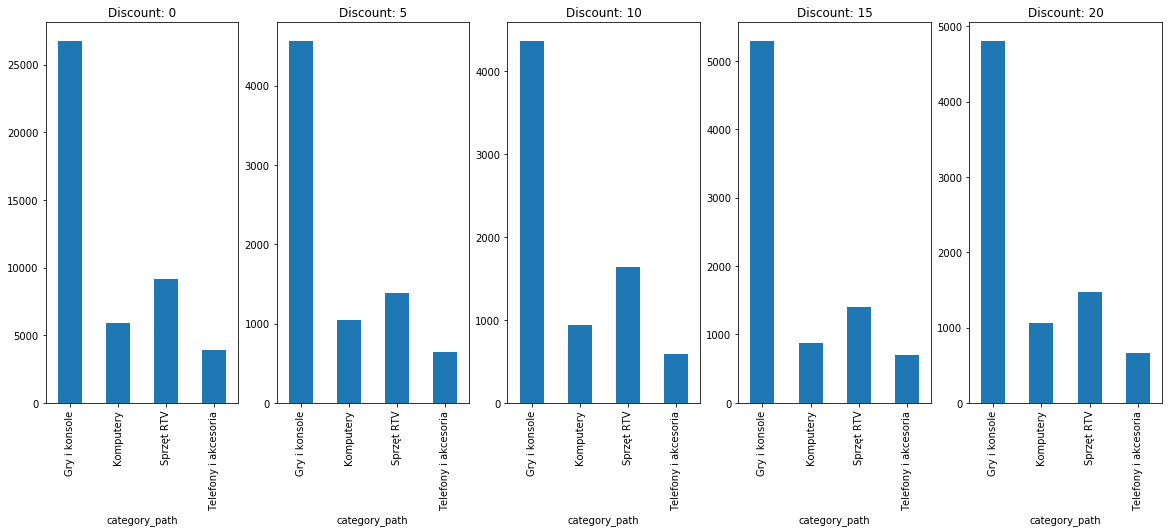

In [27]:
df['category_path'] = df['category_path'].str.replace(';.*', '')
plt.figure(figsize=(20, 7))
for i, discount in enumerate(discounts):
  plt.subplot(1, len(discounts), i+1)
  plt.title(f'Discount: {discount}')
  temp = df[df['offered_discount'] == discount]
  temp.groupby(['category_path'])['category_path'].count().plot(kind='bar')
plt.show()

Wygląda na to, że fakt posiadania zniżki nie wpływa też na to, produkty której kategorii klienci kupują. **Ostatecznie stwierdzamy, że zniżka jest nieistotna i nie będziemy jej używać w naszym modelu**.

<h1>Analiza sesji</h1>

In [28]:
df = df_products.set_index('product_id')
df = df_sessions.join(df, on='product_id')
df.shape

(86923, 10)

In [29]:
print('Liczba unikalnych sesji:', len(df['session_id'].unique()))

Liczba unikalnych sesji: 10650


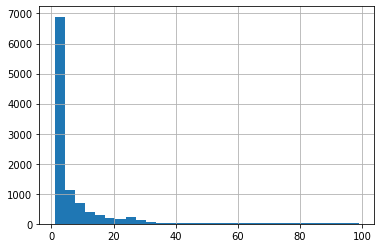

In [30]:
df.groupby('session_id')['session_id'].count().hist(bins=30)

In [31]:
df['category_path'].nunique() # dla upewnienia się

15

In [32]:
unique_categories = df.groupby('session_id')['category_path'].nunique()
unique_categories.max()

1

Zauważamy, że w każdej sesji jest przeglądany tylko jeden rodzaj produktów. Na podstawie tego jesteśmy w stanie potwierdzić naszą intuicję, że produkty przeglądane w ramach sesji nie są losowe tylko podobne do przeglądanych wcześniej produktów. 
<br>**Nasz model może zatem wykorzystywać informacje o aktualnej sesji do polecania kolejnych produktów wartych obejrzenia.**

<h1>Analiza użytkowników</h1>

Do dalszej analizy usuwamy rekordy z zakupami - zostawiamy tylko rekordy, gdzie produkt został obejrzany. Robimy to dlatego, że każdy produkt który został zakupiony został wcześniej obejrzany, a my chcemy uniknąć takich powtórek przy kolejnych analizach.

In [33]:
print(df.shape)
df = df[df['event_type'] == 'VIEW_PRODUCT']
print(df.shape)

(86923, 10)
(78800, 10)


In [34]:
df.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,100001,2020-03-26 22:22:04,102.0,1276,VIEW_PRODUCT,0,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
2,100002,2020-01-02 01:45:52,102.0,1234,VIEW_PRODUCT,5,NaN,Sony DVP-SR760,Sprzęt RTV;Video;Odtwarzacze DVD,193.00
3,100002,2020-01-02 01:48:45,102.0,1233,VIEW_PRODUCT,5,NaN,Manta DVD064,Sprzęt RTV;Video;Odtwarzacze DVD,109.00
5,100003,2020-07-31 11:31:11,102.0,1276,VIEW_PRODUCT,20,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
7,100004,2020-03-25 19:02:03,102.0,1041,VIEW_PRODUCT,0,NaN,Crysis 3 (PS3),Gry i konsole;Gry na konsole;Gry PlayStation3,79.90


In [35]:
print(df_sessions.shape)
df_sessions = df_sessions[df_sessions['event_type'] == 'VIEW_PRODUCT']
print(df_sessions.shape)

(86923, 7)
(78800, 7)


In [36]:
def get_embeddings(users):
    embeddings = users.groupby(['user_id', 'category_path'])['category_path'].count().unstack(level=1)
    embeddings = embeddings.fillna(0.0)
    embeddings = embeddings.div(embeddings.sum(axis=1), axis=0)
    
    return embeddings

In [37]:
users_embeddings = get_embeddings(df)

In [38]:
users_embeddings.head()

category_path,Gry i konsole;Gry komputerowe,Gry i konsole;Gry na konsole;Gry PlayStation3,Gry i konsole;Gry na konsole;Gry Xbox 360,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,Komputery;Monitory;Monitory LCD,Komputery;Tablety i akcesoria;Tablety,Sprzęt RTV;Audio;Słuchawki,Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,Sprzęt RTV;Video;Odtwarzacze DVD,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe,Telefony i akcesoria;Telefony komórkowe,Telefony i akcesoria;Telefony stacjonarne
user_id,,,,,,,,,,,,,,,
102.0,0.454112,0.015495,0.227652,0.013111,0.060787,0.011919,0.008343,0.003576,0.010727,0.145411,0.003576,0.013111,0.017878,0.007151,0.007151
103.0,0.000000,0.106383,0.127660,0.042553,0.297872,0.085106,0.021277,0.021277,0.021277,0.191489,0.021277,0.000000,0.021277,0.042553,0.000000
104.0,0.168889,0.062222,0.124444,0.124444,0.000000,0.022222,0.004444,0.017778,0.013333,0.351111,0.008889,0.040000,0.035556,0.013333,0.013333
105.0,0.575630,0.086134,0.117647,0.060924,0.063025,0.023109,0.004202,0.008403,0.012605,0.002101,0.010504,0.002101,0.021008,0.006303,0.006303
106.0,0.613445,0.016807,0.179272,0.053221,0.067227,0.014006,0.005602,0.005602,0.016807,0.000000,0.005602,0.014006,0.005602,0.000000,0.002801


In [39]:
users_embeddings.sum(axis=1).head() # Sprawdzenie czy zadziałało

user_id
102.0    1.0
103.0    1.0
104.0    1.0
105.0    1.0
106.0    1.0
dtype: float64

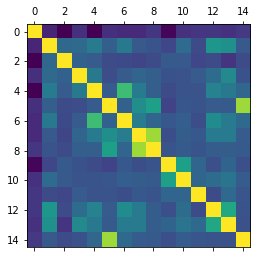

In [40]:
corr = users_embeddings.corr()
plt.matshow(corr)
plt.show()

In [41]:
corr.style.background_gradient(cmap='coolwarm')

category_path,Gry i konsole;Gry komputerowe,Gry i konsole;Gry na konsole;Gry PlayStation3,Gry i konsole;Gry na konsole;Gry Xbox 360,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,Komputery;Monitory;Monitory LCD,Komputery;Tablety i akcesoria;Tablety,Sprzęt RTV;Audio;Słuchawki,Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,Sprzęt RTV;Video;Odtwarzacze DVD,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe,Telefony i akcesoria;Telefony komórkowe,Telefony i akcesoria;Telefony stacjonarne
category_path,,,,,,,,,,,,,,,
Gry i konsole;Gry komputerowe,1.000000,-0.276227,-0.426551,-0.228180,-0.428749,-0.235485,-0.253295,-0.256942,-0.204522,-0.408279,-0.223871,-0.202189,-0.197136,-0.222620,-0.190144
Gry i konsole;Gry na konsole;Gry PlayStation3,-0.276227,1.000000,0.053505,0.067510,0.165170,0.003148,0.148763,-0.028171,-0.057166,-0.122250,0.072056,-0.104337,0.320454,0.289226,-0.028760
Gry i konsole;Gry na konsole;Gry Xbox 360,-0.426551,0.053505,1.000000,0.015479,-0.018872,-0.099690,-0.107350,-0.132514,-0.097823,-0.026673,-0.031228,-0.123694,-0.095554,-0.210123,-0.094039
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,-0.228180,0.067510,0.015479,1.000000,0.149630,-0.092748,-0.020751,0.039116,0.006321,-0.070271,-0.061649,-0.018281,0.077715,0.244496,-0.071237
Komputery;Monitory;Monitory LCD,-0.428749,0.165170,-0.018872,0.149630,1.000000,-0.021233,0.553564,0.162506,0.003784,-0.096765,-0.059938,-0.063537,0.203998,0.150151,0.041876
Komputery;Tablety i akcesoria;Tablety,-0.235485,0.003148,-0.099690,-0.092748,-0.021233,1.000000,0.014314,0.275890,0.377052,-0.143198,-0.048212,-0.057952,-0.018113,-0.022775,0.793495
Sprzęt RTV;Audio;Słuchawki,-0.253295,0.148763,-0.107350,-0.020751,0.553564,0.014314,1.000000,0.170564,0.035884,-0.035500,-0.003628,-0.084927,0.267347,0.157499,0.059634
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,-0.256942,-0.028171,-0.132514,0.039116,0.162506,0.275890,0.170564,1.000000,0.798261,-0.083185,-0.006923,-0.037671,0.159887,0.160406,-0.011659
Sprzęt RTV;Video;Odtwarzacze DVD,-0.204522,-0.057166,-0.097823,0.006321,0.003784,0.377052,0.035884,0.798261,1.000000,-0.055990,-0.021998,-0.057696,-0.005586,-0.005850,-0.022170


In [42]:
corr[corr!=1.0].max()

category_path
Gry i konsole;Gry komputerowe                                       -0.190144
Gry i konsole;Gry na konsole;Gry PlayStation3                        0.320454
Gry i konsole;Gry na konsole;Gry Xbox 360                            0.053505
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne       0.244496
Komputery;Monitory;Monitory LCD                                      0.553564
Komputery;Tablety i akcesoria;Tablety                                0.793495
Sprzęt RTV;Audio;Słuchawki                                           0.553564
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4             0.798261
Sprzęt RTV;Video;Odtwarzacze DVD                                     0.798261
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV                   0.378673
Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D                   0.378673
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące    0.057775
Telefony i akcesoria;Akcesoria telefoniczne;Zestaw

In [43]:
corr.min()

category_path
Gry i konsole;Gry komputerowe                                       -0.428749
Gry i konsole;Gry na konsole;Gry PlayStation3                       -0.276227
Gry i konsole;Gry na konsole;Gry Xbox 360                           -0.426551
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne      -0.228180
Komputery;Monitory;Monitory LCD                                     -0.428749
Komputery;Tablety i akcesoria;Tablety                               -0.235485
Sprzęt RTV;Audio;Słuchawki                                          -0.253295
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4            -0.256942
Sprzęt RTV;Video;Odtwarzacze DVD                                    -0.204522
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV                  -0.408279
Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D                  -0.223871
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące   -0.202189
Telefony i akcesoria;Akcesoria telefoniczne;Zestaw

Stwórzmy teraz syntetyczny dataset z użytkownikami w celu sprawdzenia, czy wybieranie losowo sesji da nam podobne korelacje, co te prawdziwe.

In [44]:
import random

def generate_users(n_users):
    users_sessions = df.groupby('user_id')['session_id'].nunique()
    sessions = df['session_id'].unique()

    generated_sessions = {'user_id': [], 'session_id': []}
    for i in range(n_users):
        idx = random.sample(list(sessions), users_sessions.iloc[i % len(users_sessions)])
        for index in idx:
            generated_sessions['user_id'].append(i)
            generated_sessions['session_id'].append(index)

    generated_sessions = pd.DataFrame(generated_sessions)
    
    df_gen = generated_sessions.set_index('session_id')
    df_gen = df_sessions.drop(columns='user_id').join(df_gen, on='session_id')
    df_temp = df_products.set_index('product_id')
    df_gen = df_gen.join(df_temp, on='product_id')
    return df_gen

In [45]:
# it can take up to a minute
gen_users = generate_users(len(users_embeddings) * 100) # * 100 to generate larger sample
gen_users_embeddings = get_embeddings(gen_users) 

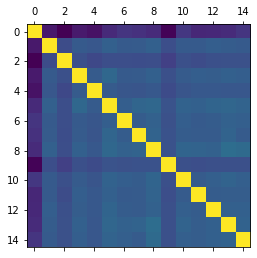

In [46]:
gen_corr = gen_users_embeddings.corr()
plt.matshow(gen_corr)
plt.show()

In [47]:
gen_corr.style.background_gradient(cmap='coolwarm')

category_path,Gry i konsole;Gry komputerowe,Gry i konsole;Gry na konsole;Gry PlayStation3,Gry i konsole;Gry na konsole;Gry Xbox 360,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,Komputery;Monitory;Monitory LCD,Komputery;Tablety i akcesoria;Tablety,Sprzęt RTV;Audio;Słuchawki,Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,Sprzęt RTV;Video;Odtwarzacze DVD,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe,Telefony i akcesoria;Telefony komórkowe,Telefony i akcesoria;Telefony stacjonarne
category_path,,,,,,,,,,,,,,,
Gry i konsole;Gry komputerowe,1.000000,-0.286887,-0.378726,-0.279038,-0.312001,-0.216146,-0.163732,-0.180461,-0.210788,-0.367194,-0.152999,-0.224191,-0.220454,-0.211060,-0.164134
Gry i konsole;Gry na konsole;Gry PlayStation3,-0.286887,1.000000,-0.059606,0.012024,-0.006490,0.041930,0.011095,0.016357,0.044554,-0.046282,0.013332,0.012882,0.030659,0.021811,0.011893
Gry i konsole;Gry na konsole;Gry Xbox 360,-0.378726,-0.059606,1.000000,-0.043452,-0.077319,-0.049956,-0.045361,-0.053288,-0.045027,-0.117841,-0.043815,-0.058559,-0.043768,-0.038694,-0.039418
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,-0.279038,0.012024,-0.043452,1.000000,0.014909,0.080175,0.012030,0.016800,0.045796,-0.043872,0.016297,0.034632,0.026509,0.041437,0.034746
Komputery;Monitory;Monitory LCD,-0.312001,-0.006490,-0.077319,0.014909,1.000000,0.016525,-0.010551,-0.015706,-0.001304,-0.065591,-0.015299,-0.000240,0.000609,-0.004505,-0.002598
Komputery;Tablety i akcesoria;Tablety,-0.216146,0.041930,-0.049956,0.080175,0.016525,1.000000,0.035782,0.072793,0.079334,-0.027127,0.052804,0.045030,0.066960,0.078476,0.058794
Sprzęt RTV;Audio;Słuchawki,-0.163732,0.011095,-0.045361,0.012030,-0.010551,0.035782,1.000000,0.024093,0.050345,-0.038603,0.034595,0.014040,0.020024,0.051772,0.037134
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,-0.180461,0.016357,-0.053288,0.016800,-0.015706,0.072793,0.024093,1.000000,0.061340,-0.030281,0.024945,0.019304,0.018706,0.059951,0.018419
Sprzęt RTV;Video;Odtwarzacze DVD,-0.210788,0.044554,-0.045027,0.045796,-0.001304,0.079334,0.050345,0.061340,1.000000,-0.032428,0.066895,0.062604,0.050727,0.113405,0.096971


In [48]:
gen_corr[gen_corr!=1.0].max()

category_path
Gry i konsole;Gry komputerowe                                       -0.152999
Gry i konsole;Gry na konsole;Gry PlayStation3                        0.044554
Gry i konsole;Gry na konsole;Gry Xbox 360                           -0.038694
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne       0.080175
Komputery;Monitory;Monitory LCD                                      0.016525
Komputery;Tablety i akcesoria;Tablety                                0.080175
Sprzęt RTV;Audio;Słuchawki                                           0.051772
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4             0.072793
Sprzęt RTV;Video;Odtwarzacze DVD                                     0.113405
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV                  -0.027127
Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D                   0.066895
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące    0.062604
Telefony i akcesoria;Akcesoria telefoniczne;Zestaw

In [49]:
gen_corr.min()

category_path
Gry i konsole;Gry komputerowe                                       -0.378726
Gry i konsole;Gry na konsole;Gry PlayStation3                       -0.286887
Gry i konsole;Gry na konsole;Gry Xbox 360                           -0.378726
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne      -0.279038
Komputery;Monitory;Monitory LCD                                     -0.312001
Komputery;Tablety i akcesoria;Tablety                               -0.216146
Sprzęt RTV;Audio;Słuchawki                                          -0.163732
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4            -0.180461
Sprzęt RTV;Video;Odtwarzacze DVD                                    -0.210788
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV                  -0.367194
Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D                  -0.152999
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące   -0.224191
Telefony i akcesoria;Akcesoria telefoniczne;Zestaw

In [50]:
corr_diff = (gen_corr - corr).abs()
corr_diff.style.background_gradient(cmap='coolwarm')

category_path,Gry i konsole;Gry komputerowe,Gry i konsole;Gry na konsole;Gry PlayStation3,Gry i konsole;Gry na konsole;Gry Xbox 360,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,Komputery;Monitory;Monitory LCD,Komputery;Tablety i akcesoria;Tablety,Sprzęt RTV;Audio;Słuchawki,Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,Sprzęt RTV;Video;Odtwarzacze DVD,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe,Telefony i akcesoria;Telefony komórkowe,Telefony i akcesoria;Telefony stacjonarne
category_path,,,,,,,,,,,,,,,
Gry i konsole;Gry komputerowe,0.000000,0.010660,0.047825,0.050859,0.116748,0.019338,0.089563,0.076481,0.006266,0.041085,0.070871,0.022002,0.023318,0.011560,0.026010
Gry i konsole;Gry na konsole;Gry PlayStation3,0.010660,0.000000,0.113112,0.055486,0.171661,0.038782,0.137668,0.044527,0.101720,0.075968,0.058724,0.117219,0.289794,0.267415,0.040653
Gry i konsole;Gry na konsole;Gry Xbox 360,0.047825,0.113112,0.000000,0.058932,0.058447,0.049733,0.061989,0.079226,0.052796,0.091168,0.012587,0.065135,0.051786,0.171429,0.054621
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,0.050859,0.055486,0.058932,0.000000,0.134722,0.172923,0.032781,0.022316,0.039475,0.026400,0.077946,0.052913,0.051206,0.203059,0.105984
Komputery;Monitory;Monitory LCD,0.116748,0.171661,0.058447,0.134722,0.000000,0.037758,0.564116,0.178212,0.005088,0.031174,0.044639,0.063297,0.203389,0.154656,0.044474
Komputery;Tablety i akcesoria;Tablety,0.019338,0.038782,0.049733,0.172923,0.037758,0.000000,0.021468,0.203097,0.297718,0.116071,0.101016,0.102982,0.085073,0.101250,0.734701
Sprzęt RTV;Audio;Słuchawki,0.089563,0.137668,0.061989,0.032781,0.564116,0.021468,0.000000,0.146471,0.014461,0.003103,0.038223,0.098967,0.247323,0.105726,0.022500
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,0.076481,0.044527,0.079226,0.022316,0.178212,0.203097,0.146471,0.000000,0.736921,0.052904,0.031867,0.056975,0.141181,0.100455,0.030078
Sprzęt RTV;Video;Odtwarzacze DVD,0.006266,0.101720,0.052796,0.039475,0.005088,0.297718,0.014461,0.736921,0.000000,0.023562,0.088893,0.120300,0.056313,0.119254,0.119141


In [51]:
corr_diff_max = corr_diff.max().max()
corr_diff_max

0.7369205390153352

In [52]:
corr_diff_mean = corr_diff.mean().mean()
corr_diff_mean

0.0975304623164577

Wygenerujemy teraz embeddingi dla takiej samej ilości użytkowników, jaką mamy w dataset'cie. Dzięki temu sprawdzimy, czy różnice między naszymi korelacjami dla embeddingów prawdziwych użytkowników i tych wygenerowanych mogą być efektem losowości.

In [53]:
# it can take up to a minute

max_diffs = []
mean_diffs = []
unique_categories_counts = []
n_iterations = 100

for i in range(n_iterations):
    temp_users = generate_users(len(users_embeddings))
    temp_embeddings = get_embeddings(temp_users)
    temp_corr = temp_embeddings.corr()
    temp_corr_diff = (gen_corr - temp_corr).abs()
    
    max_diff = temp_corr_diff.max().max()
    mean_diff = temp_corr_diff.mean().mean()
    max_diffs.append(max_diff)
    mean_diffs.append(mean_diff)
    
    temp_unique_categories_count = temp_users.groupby('user_id')['category_path'].nunique().mean()
    unique_categories_counts.append(temp_unique_categories_count)

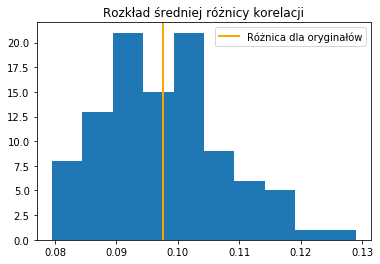

In [54]:
plt.hist(mean_diffs, bins=int(n_iterations ** 0.5))
plt.axvline(corr_diff_mean, color='orange', linewidth=2)
plt.title('Rozkład średniej różnicy korelacji')
plt.legend(['Różnica dla oryginałów'])
plt.show()

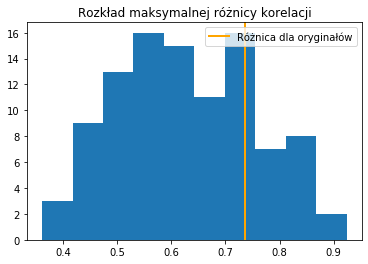

In [55]:
plt.hist(max_diffs, bins=int(n_iterations ** 0.5))
plt.axvline(corr_diff_max, color='orange', linewidth=2)
plt.title('Rozkład maksymalnej różnicy korelacji')
plt.legend(['Różnica dla oryginałów'])
plt.show()

In [56]:
original_categories_counts = df.groupby('user_id')['category_path'].nunique().mean()
original_categories_counts

13.04

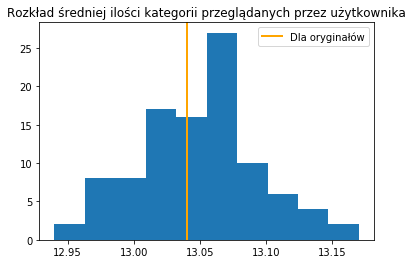

In [57]:
plt.hist(unique_categories_counts, bins=int(n_iterations ** 0.5))
plt.axvline(original_categories_counts, color='orange', linewidth=2)
plt.title('Rozkład średniej ilości kategorii przeglądanych przez użytkownika')
plt.legend(['Dla oryginałów'])
plt.show()

Jak widać korelacje dla prawdziwych użytkowników niewiele różnią się od korelacji dla wygenerowanych użytkowników - można uznać, że różnica ta jest spowodowana losowością. Z tego wynika, wbrew naszym oczekiwaniom, że użytkownicy nie mają żadnych preferencji co do kategorii produktów, które oglądają. Możemy uznać więc, że historia użytkownika nie dostarcza nam żadnych nowych informacji, a system polecania warto robić używając jedynie historii aktualnej sesji.